In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Tuple, Any
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

#### Step 1. Get Train, val, test, and pred datasets

In [12]:
def features_target_split(df:pd.DataFrame, col:str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Split features and target values

    Input:
    data (pd.DataFrame) : input DataFrame with features and target values
    col (str) : name of the target value column

    Output:
    X (pd.DataFrame): DataFrame with features
    y (pd.DataFrame): DataFrame with target values
    '''
    X = df.drop(columns=[col])
    y = df[[col]]  

    return X, y

def train_test_split(df:pd.DataFrame, col:str, ratio: float = 0.75) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Split inputs into 2 sets of data: training (train) and test (test).
    Each set of data is splitted into features (X) and target values (y).

    Input:
    data (pd.DataFrame) : input DataFrame with features and target values
    col (str) : name of the target value column
    ratio (float) : split ratio, between 0 and 1, to split train and validation data

    Output:
    X_train (pd.DataFrame): DataFrame for training with features
    y_train (pd.DataFrame): DataFrame for training with target values
    X_test (pd.DataFrame): DataFrame for testing with features
    y_test (pd.DataFrame): DataFrame for testing with target values
    '''
    # spint train and test sets
    df = df.sort_values(by=["DISCOVERY_DATE"])
    index_ratio = int(ratio * df.shape[0]) # find the row number where we want to split
    split_date = df.iloc[index_ratio, df.columns.get_loc("DISCOVERY_DATE")] # find the corresponding data
    data_train = df[df["DISCOVERY_DATE"] < split_date].drop(columns=["DISCOVERY_DATE"]).copy()
    data_test = df[df["DISCOVERY_DATE"] >= split_date].drop(columns=["DISCOVERY_DATE"]).copy()

    # split between features and target values
    X_train, y_train = features_target_split(data_train, col)
    X_test, y_test = features_target_split(data_test, col)
    
    return X_train, y_train, X_test, y_test

In [13]:
# inputs
data = pd.read_csv("./data/4_input_model/model_1.csv", index_col=["FOD_ID"], parse_dates=["DISCOVERY_DATE"])
min_year_pred = 2015
target_col = "CAUSE_CODE"
ratio = 0.75

# find max number of occurrence per day
max_occ_day = data.groupby("DISCOVERY_DATE").agg({"FIRE_YEAR":"count"}).max().values[0]

# split train and prediction datasets
X_pred = data[data["FIRE_YEAR"] >= min_year_pred].copy()
X_pred.drop(columns=["CAUSE_CODE", "DISCOVERY_DATE"], inplace=True) # get features for predictions
data = data[data["FIRE_YEAR"] < min_year_pred].copy() # get train data (features and target values)
data[target_col] = data[target_col].astype("int")

# split train, val and test sets
X_train_val, y_train_val, X_test, y_test = train_test_split(data, target_col, ratio)

#### Step 2. Use Train data for parameters tuning

In [14]:
def model_fit_predict(X_train:pd.DataFrame, y_train:pd.DataFrame, X_val:pd.DataFrame) -> Tuple[pd.DataFrame, Any]:
    '''
    Create a model, fit it on X_train and y_train, and predict the target values from X_val

    Input:
    X_train (pd.DataFrame) : input DataFrame with features for training
    y_train (pd.DataFrame) : input DataFrame with target values for training
    X_val (pd.DataFrame) : input DataFrame with features for validation

    Output:
    y_pre (pd.DataFrame): predictions based on the features from X_val
    model : trained model
    '''
    model = RandomForestClassifier()
    model.fit(X_train, y_train.values.ravel())
    y_pre = model.predict(X_val)
    return y_pre, model


def scoring(y_true:pd.DataFrame, y_pre:pd.DataFrame) -> dict:
    '''
    Return a dictionary with keys corresponding to score name and values corresponding to the associated score

    Input:
    y_true (pd.DataFrame) : input DataFrame with true labels
    y_pre (pd.DataFrame) : input DataFrame with predicted labels

    Output:
    (dict): output dictionary with scores
    '''
    return {
        "f1-micro": f1_score(y_true, y_pre, average="micro"),
        "f1-macro": f1_score(y_true, y_pre, average="macro"),
        "f1-weighted": f1_score(y_true, y_pre, average="weighted"),
        "accuracy": accuracy_score(y_true, y_pre)
    }


def print_scoring(scores:dict) -> None:
    '''
    Print scores from a dictionary

    Input:
    scores (dict) : dictionary with keys corresponding to score name and values corresponding to the associated score

    Output:
    None
    '''
    for name, score in scores.items():
        print(f"{name}: {score}")


def plot_confusion_matrix(y_test:pd.DataFrame, y_pre:pd.DataFrame, nb_values:int) -> None:
    '''
    Plot the confusion matrix based on the provided true and predicted labels

    Input:
    y_true (pd.DataFrame) : input DataFrame with true labels
    y_pre (pd.DataFrame) : input DataFrame with predicted labels
    nb_values (int) : nb of target values

    Output:
    None
    '''
    sns.heatmap(
        confusion_matrix(y_test, y_pre),
        xticklabels=range(nb_values),
        yticklabels=range(nb_values),
        annot=True,
        cmap='Blues',
        fmt='g',
        cbar=False
    )
    plt.show()


def rf_features_importance(model: Any, cols:list) -> None:
    '''
    Plot feature_importance from a random forest model

    Input:
    y_true (pd.DataFrame) : input DataFrame with true labels
    y_pre (pd.DataFrame) : input DataFrame with predicted labels

    Output:
    None
    '''
    # get feature importance from model
    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=cols).sort_values(ascending=False)[:10]
    # plot results
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances")
    fig.tight_layout()
 

def cross_validation_score(X_train_val:pd.DataFrame, y_train_val:pd.DataFrame, gap:int) -> Any:
    '''
    Cross validation for time series, with 5 splits

    Input:
    X_train_val (pd.DataFrame) : input DataFrame with features for training
    y_train_val (pd.DataFrame) : input DataFrame with target values for training
    gap (int) : number of entries between 2 sets during the cross-validation

    Output:
    model: trained model
    '''
    # cross-validation for time series
    tscv = TimeSeriesSplit(gap=gap, n_splits=3)
    y_pre, y_val, model = None, None, None
    scores_history = []
    i = 0
    for train_index, val_index in tscv.split(X_train_val):
        i += 1 # increase iteration
        # get datasets (train and val)
        train_index = list(train_index)
        val_index = list(val_index)
        X_train, X_val = X_train_val.iloc[train_index, :], X_train_val.iloc[val_index, :]
        y_train, y_val = y_train_val.iloc[train_index, :], y_train_val.iloc[val_index, :]
        # fit model and predict y_val
        y_pre, model = model_fit_predict(X_train, y_train, X_val)
        # scoring
        scores = scoring(y_val, y_pre)
        scores_history.append(scores)
        print("")
        print(f"Step {i}")
        print_scoring(scores)

    return model

In [15]:
# train model on X_train_val and y_train_val
model = cross_validation_score(X_train_val, y_train_val, gap = max_occ_day)


Step 1
f1-micro: 0.5601947876273785
f1-macro: 0.50509497031884
f1-weighted: 0.5473222550050694
accuracy: 0.5601947876273785

Step 2
f1-micro: 0.5827757236901434
f1-macro: 0.5369670387414447
f1-weighted: 0.5737358714681694
accuracy: 0.5827757236901434

Step 3
f1-micro: 0.6204527008747407
f1-macro: 0.568168113864272
f1-weighted: 0.6098237487984846
accuracy: 0.6204527008747407


#### Step 3. Test the model on the Test set, and refit the model on the entire data set

In [16]:
# to be done only few times (risk of overfitting)
def score_test_set(model:Any, X_train_val:pd.DataFrame, y_train_val:pd.DataFrame, X_test:pd.DataFrame, y_test:pd.DataFrame) -> None:
    '''
    Fit the model on the entire X_train_val and y_train_val data, and predict values for the test set

    Input:
    model : model used for training the the previous section of the notebook
    X_train_val (pd.DataFrame) : input DataFrame with features for training
    y_train_val (pd.DataFrame) : input DataFrame with target values for training
    X_test (pd.DataFrame) : input DataFrame with features for testing
    y_test (pd.DataFrame) : input DataFrame with target values for testing

    Output:
    None
    '''
    # fit model on entire X_train_val, y_train_val datasets
    model.fit(X_train_val, y_train_val.values.ravel())
    y_pred = model.predict(X_test)
    # score test set
    scores = scoring(y_test, y_pred)
    print_scoring(scores)
    # plot the last confusion matrix
    plot_confusion_matrix(y_test, y_pred, nb_values=4)
    # plot features importance
    cols = X_train_val.columns # get columns names
    rf_features_importance(model, cols) # plot feature importance

f1-micro: 0.657365031792961
f1-macro: 0.588666324813126
f1-weighted: 0.6469052604573996
accuracy: 0.657365031792961


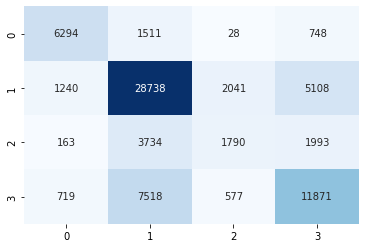

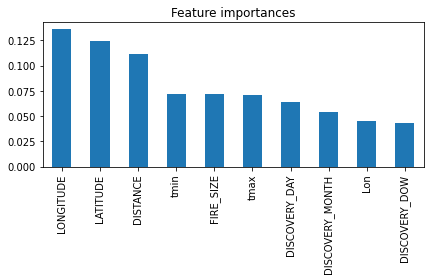

In [17]:
score_test_set(model, X_train_val, y_train_val, X_test, y_test)

#### Step 4. Create the submission file

In [18]:
def fit_model_all_data(model:Any, X_train_val:pd.DataFrame, y_train_val:pd.DataFrame, X_test:pd.DataFrame, y_test:pd.DataFrame):
    '''
    Fit the model on the entire X_train_val and X_test features

    Input:
    model : model used for training the the previous section of the notebook
    X_train_val (pd.DataFrame) : input DataFrame with features for training
    y_train_val (pd.DataFrame) : input DataFrame with target values for training
    X_test (pd.DataFrame) : input DataFrame with features for testing
    y_test (pd.DataFrame) : input DataFrame with target values for testing

    Output:
    model : model trained on all available data
    '''
    # fit model on entire X_train_val, y_train_val datasets
    X = pd.concat([X_train_val, X_test])
    y = pd.concat([y_train_val, y_test])
    model.fit(X, y.values.ravel())
    return model
    

def save_predictions(X_pred:pd.DataFrame, model, filename:str) -> None:
    '''
    Save predictions (year 2015) to csv format, based on a provided pre-trained model, and features for predictions X_pred

    Input:
    X_pred (pd.DataFrame) : input DataFrame with features for predictions
    model : input pre-trained model, which has a predict method
    filename (str) : Name of the file for submission

    Output:
    None
    '''
    # predict target values
    y_pred = model.predict(X_pred)
    # create a DataFrame with results
    submission = pd.DataFrame(
        data=y_pred,
        index=X_pred.index,
        columns=["CAUSE_CODE"]
    ).reset_index()
    # save to csv
    submission.to_csv(f"./data/5_predictions/{filename}.csv", index=False)

In [19]:
# save predictions to csv
filename = "submission_group_X_model_1"
model = fit_model_all_data(model, X_train_val, y_train_val, X_test, y_test)
save_predictions(X_pred, model, filename)